# Metric visualisation from stored metric data

Import libraries

In [1]:
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Define functions

In [2]:
# --- Visualization Functions ---
def configure_plot_fonts(base_size=20):
    plt.rcParams.update({
        'font.size': base_size + 2,
        'axes.titlesize': base_size + 4,
        'axes.labelsize': base_size + 2,
        'xtick.labelsize': base_size,
        'ytick.labelsize': base_size,
        'legend.fontsize': base_size
    })

def plot_metric_results(metrics_data, averages_data, metrics_classes):
    """Visualize line plots and heatmaps for each metric."""
    num_metrics = len(metrics_data)
    fig, axs = plt.subplots(2, num_metrics, figsize=(6 * num_metrics, 10), sharey='row')
    axs = np.array(axs).reshape(2, num_metrics)

    timesteps = range(1, len(metrics_data[0][0]) + 1)

    for i, (top_ax, bottom_ax, sim_avg, (data, labels, label_pos), metric_cls) in enumerate(zip(
        axs[0], axs[1], averages_data, metrics_data, metrics_classes
    )):
        *individual_avgs, avg_all = sim_avg

        # Line plot
        for avg in individual_avgs:
            top_ax.plot(timesteps, avg, color='gray', linestyle='--', marker='o', alpha=0.7)
        top_ax.plot(timesteps, avg_all, color='red', marker='o', linewidth=2)
        top_ax.set_title(metric_cls.__name__)
        top_ax.set_xticklabels([])
        if i == 0:
            top_ax.set_ylabel("Average Value")
        else:
            top_ax.set_yticklabels([])
        top_ax.grid(True)

        # Heatmap
        cax = bottom_ax.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
        bottom_ax.set_xlabel("Time")
        bottom_ax.set_xticks(range(data.shape[0]))
        bottom_ax.set_xticklabels(range(data.shape[0]))
        if i == 0:
            bottom_ax.set_ylabel("Order")
            bottom_ax.set_yticks(list(label_pos.values()))
            bottom_ax.set_yticklabels(labels)

    plt.tight_layout(h_pad=0.1)
    plt.show()

def main(data_dir, metrics_classes):
    heatmap_path = os.path.join(data_dir, "heatmap_data.pkl")
    averages_path = os.path.join(data_dir, "averages_data.pkl")

    with open(heatmap_path, "rb") as f:
        heatmap_data = pickle.load(f)
    with open(averages_path, "rb") as f:
        averages_data = pickle.load(f)

    configure_plot_fonts()
    plot_metric_results(heatmap_data, averages_data, metrics_classes)

Visualise metric results for the desired dataset

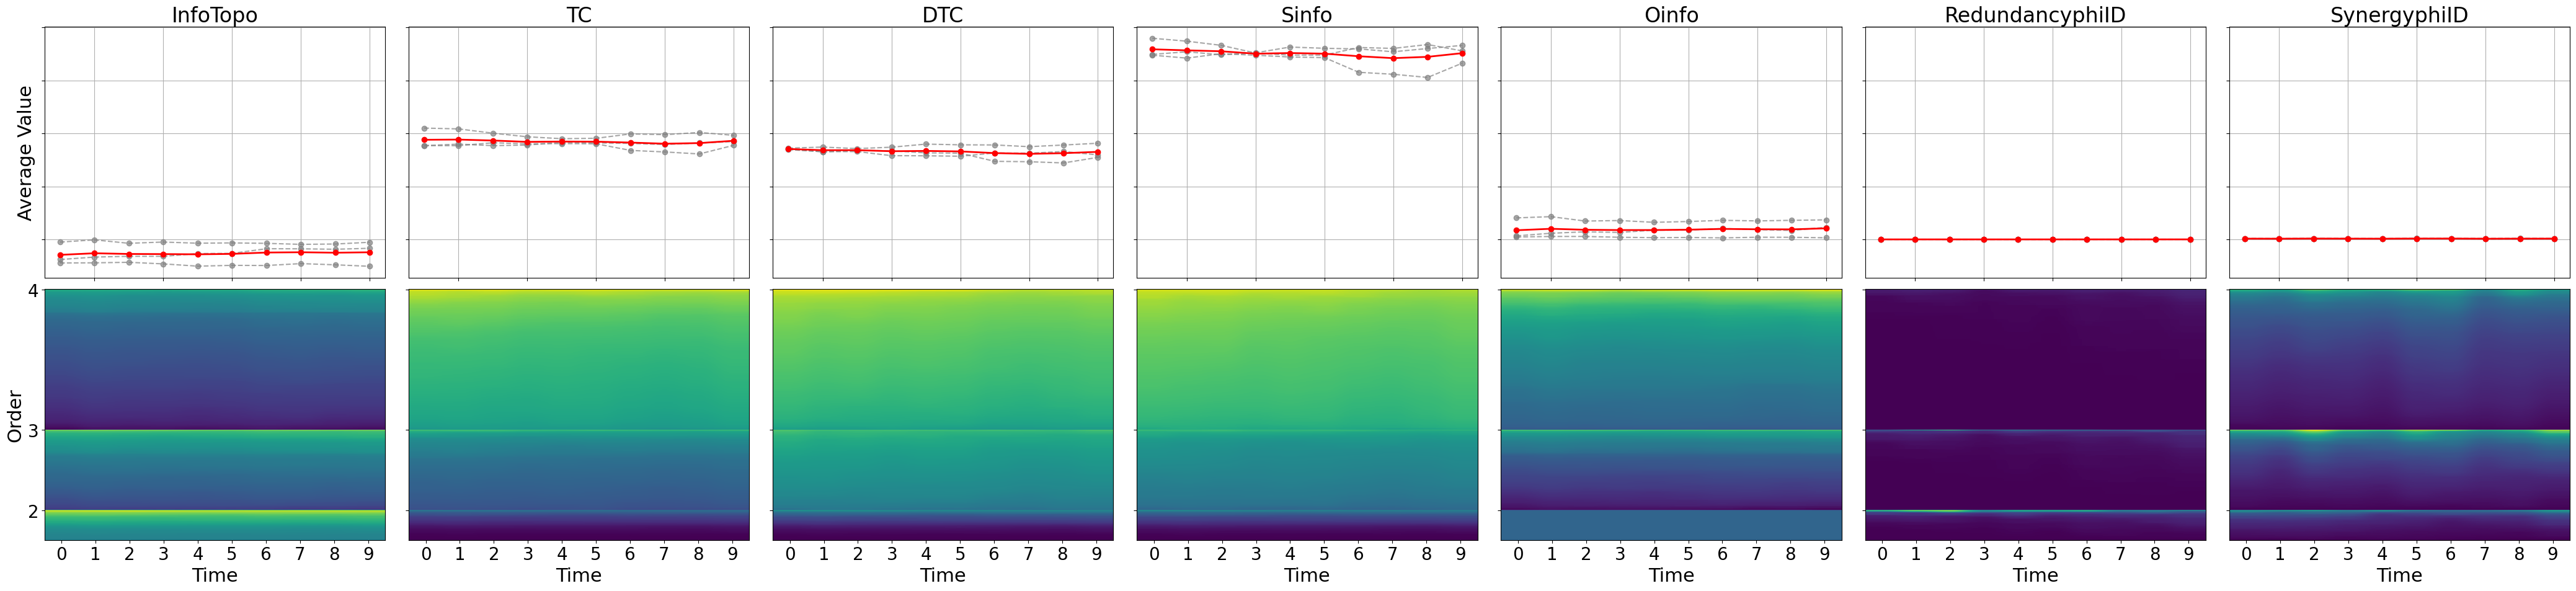

In [5]:
data_directory = r'Data\Artificial_data\Synergistic_timeseries'
metrics = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]
main(data_directory, metrics)

NEXT STEP, MAKE SURE ALL METRICS ARE NORMALISED SO THAT THEY CAN BE PLOTTED BETWEEN -1 AND 1. ADD A HLINE=0 FOR COMPARISON